# 1. CNN 모델 만들기 

#### 1) 데이터셋을 64 * 64 사이즈로 조절하기 
#### 2) 데이터를 0~1 사이의 값으로 만들고, 차원 확장하기
#### 3) Training 데이터와 Test 데이터 분리하기
#### 4) CNN Model 생성하기
#### 5) model 컴파일링하기
#### 6) model 훈련시키기
#### 7) model로 테스트 이미지 실험해보기
#### 8) Confusion Matrix 확인하기

### Tensorflow 가 없다는 오류가 뜨신다면

<prompt에서 설치하기>
1) Anaconda prompt를 관리자모드로 열어줍니다.

2) 명령어를 입력합니다: 
` conda update --force conda `

3) 명령어를 입력합니다:
` conda install tensorflow `

4) jupyter를 다시 실행합니다.

<br />

<anaconda navigator 에서 설치하기>
1) Anaconda navigator 를 연 뒤, environment 에서 tensorflow를 검색합니다.

2) tensorflow 항목을 선택한 뒤 다운로드 받습니다.

3) jupyter를 다시 실행합니다.

### protobuf downgrade 오류가 뜨신다면

1) Anaconda prompt (관리자모드) 에서 명령어를 입력합니다: `pip uninstall protobuf`

2) Anaconda prompt (관리자모드) 에서 명령어를 입력합니다: `pip install protobuf==3.19.0`

3) jupyter 를 다시 실행합니다.

<br />

 **항상 고생해주셔서 감사합니다!😊**

### CNN 모델을 만들 때 필요한 라이브러리

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf #딥러닝 인공지능 기법을 구현하기 쉽게 도와주는 라이브러리
from glob import glob #dataset 의 사진 파일을 list로 불러올 수 있게 도와주는 라이브러리
from tqdm import tqdm #반복문 진행률을 시각화해주는 라이브러리
from PIL import Image #이미지 분석 및 처리를 쉽게할 수 있게 도와주는 라이브러리

from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 1) 데이터셋을 64 * 64 사이즈로 조절하기 

1) glob 은 인자로 전달받은 경로명에서 패턴(이 코드에서는 * 이므로 모든 파일)이 일치하는 파일들을 리스트로 반환합니다.

2) tqdm 은 순회 가능한 객체를 for로 순회할 때, 진행률이 얼마나 되었는지를 보여주는 함수입니다.

In [6]:
X = []
Y = []
#눈 뜬 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/train/Open_Eyes/*')): #사진파일을 리스트로 불러옵니다.
    temp = np.array(Image.open(i).resize((64,64))) #64*64사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    X.append(temp)
    Y.append(1) #눈 뜬 사진의 라벨은 1로 설정합니다.
    
#눈 감은 사진 사이즈 조절 및 numpy 객체로 만들기
for i in tqdm(glob('./archive/train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64))) #마찬가지로 64*64 사이즈로 만든 뒤 numpy 배열 객체로 만듭니다.
    X.append(temp)
    Y.append(0)  #눈 감은 사진의 라벨은 0으로 설정합니다.

100%|██████████| 2000/2000 [00:01<00:00, 1980.29it/s]


### 2) 데이터를 0~1 사이의 값으로 만들고, 차원 확장하기

Min-Max scailing algorithm: 본래 눈 데이터의 정규분포를 오염시키고 싶지 않아 해당 방법을 선택하였습니다.

In [7]:
X = (np.array(X) - np.min(X)) / (np.max(X) - np.min(X))
X = X/255.0 #픽셀값은 0~255 사이이므로, 이 값을 0~1로 조절하기 위해 255로 나누기 진행
Y = (np.array(Y) - np.min(Y)) / (np.max(Y) - np.min(Y))

print(X.shape) # (4000, 64, 64)
X = np.expand_dims(X,-1) #가장 끝쪽의 차원을 추가하여 확대합니다. (흑백데이터이므로 1)
print(X.shape) #(64, 64, 1) 로 잘 됐는지 확인하기

(4000, 64, 64)
(4000, 64, 64, 1)


### 3) Training 데이터와 Test 데이터 분리하기

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

#random_state는 아무 숫자나 넣으면 되기 때문에 사람들이 자주 사용하는 42를 넣었습니다.

### 4) CNN Model 생성하기

사진 데이터를 인공 신경망에 input 할 때 1차원 배열의 형태로 넣게 되면 공간 정보가 손실됩니다.
따라서 이미지의 공간 정보를 유지한 상태로 학습을 하고자 CNN 모델을 선정하게 되었습니다.
13주차에서 배운 tensorflow.keras.models 와 tensorflow.keras.layers를 응용하였습니다.

<br />

CNN: convolution layer + pooling layer를 반복하여 구성, 특징 표현을 학습시켜 눈을 감았는지 떴는지 판별하는 딥러닝의 신경망 아키텍쳐

필터는 convolution layer를 훑으면서 Inner product(두 행렬의 각 위치에 있는 숫자를 모두 곱한 뒤 더해주는 연산) 을 하고, 이 과정은 이미지의 모든 영역에 반복적으로 수행됩니다. 결과적으로 이미지의 패턴을 찾아낼 수 있게 됩니다.
<br />

1) convolution layer 의 동작에는 filter(그림에서는 연산자의 우측 항)필요하고 이들의 연산은 아래 사진과 같습니다. (출처: https://rubber-tree.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D-%EB%AA%A8%EB%8D%B8-CNN-Convolutional-Neural-Network-%EC%84%A4%EB%AA%85)
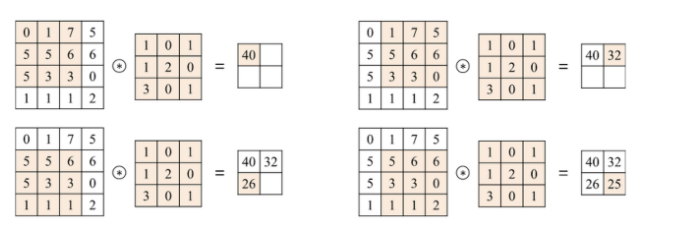

<br />

2) pooling은 이미지 인식 분야에서 주로 사용하는 max pooling을 선택합니다. 2 * 2 (겹치는 부분이 없게 하기 위해) 사이즈 크기로 훑으면서 진행하며 그 중 가장 큰 값을 뽑습니다. (출처: 밑바닥부터 시작하는 딥러닝)
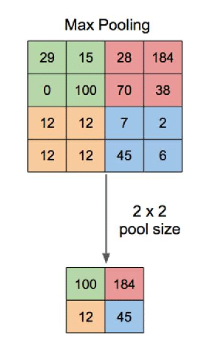

<br />

3) Flattern()은 다차원 입력을 1차원으로 변환하는 역할, 즉 이 전의 convolution layer 와 max pooling 레이어로 구성된 계층들의 출력을 받은 뒤 1차원 벡터로 펼쳐줍니다. 이렇게 다차원 구조에서 1차원 구조로 바꿔준 뒤 fully connected 계층으로 전달합니다.

<br />

4) Dense()는 fully connected 계층을 생성하는 함수입니다. 입력과 출력 사이의 모든 뉴런들이 연결된 계층을 만들어주는 것입니다. 입력데이터 * 가중치 를 계산한 뒤 활성화 함수를 통과시켜 출력을 계산하는 역할을 합니다. 

<br />

(공부 출처: 밑바닥부터 시작하는 딥러닝, https://wikidocs.net/24987, https://blog.naver.com/intelliz/221709190464 등)

In [9]:
#계층을 선형으로 쌓는 Sequential() 사용, 13주차에서 배운 내용 응용
#Sequential()은 입력층, 은닉층, 출력층 등을 구성하기 위해 사용한다.
model = Sequential([
      Input(shape=(64, 64, 1)), #입력의 크기, 흑백이므로 1

      #출처: keras 공식문서 (https://keras.io/ko/layers/convolutional/)
      #filters: convolution 필터의 개수 == 특성 맵의 개수
      #kernel_size: convolution filter의 크기, 5*5 
      #strides: 필터 윈도우가 움직이는 거리를 지정
      #use_bias: 함수를 데이터에 근사시키기 위해 사용
      #은닉층이므로 ReLU 사용, sigmoid 는 output 이 음수 값으로 나오는 것들을 0에 가깝게 표현하면서
      #weight가 변하지 않는 문제(gradient 소실)로 인해 사용하지 않았습니다.
    
      #1번째 convolution - pooling 레이어 세트
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      #Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(), #입력값을 평균 0, 분산 1로 정규화하여 학습이 잘 일어나도록 돕는 배치 정규화
      MaxPooling2D(strides = 2),
      Dropout(0.3),#과한 학습으로 인한 과적합을 줄이기 위하여 Dropout 실시

      #2번째 convolution - pooling 레이어 세트
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),
      
      Flatten(), #1차원으로 변환
      # unit: 레이어에서 생성할 뉴런의 수, 출력차원을 결정하고 많을수록 표현력이 높아진다.
      # use_bias: 편향사용여부
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),
        
      #눈을 감았는지, 떴는지만을 판단하는 이진 문제이므로 unit은 1, sigmoid 활성함수를 통과시킨다.
      Dense(units = 1, activation = 'sigmoid')
  ])

### 5) model 컴파일링하기

In [11]:
#출처: https://wikidocs.net/36033, 13주차에서 배운 내용
#이중 클래스 분류: binary_crossentropy
#최적화 알고리즘: adam [momentum 알고리즘과 RMSprop 알고리즘을 합친 느낌의 알고리즘, 뱡항과 학습률을 잡기 위해 사용]
#분류이므로 평가지표 metrics: accuracy
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 

### 6) model 훈련시키기

In [28]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='PictureLearningModel.h5', #모델 저장 path 
    save_weights_only=False,#weight가 아닌 전체 모델을 저장
    save_best_only=True, #손실이 개선되었을 때만 저장
    monitor='val_loss', #손실이 체크포인트 저장 기준
    mode='min', #손실이 가장 낮은 모델을 저장
    verbose =1) #체크포인트 저장 시 로그 메세지 출력

model.fit(x_train, y_train, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
88/88 [==============================] - 6s 61ms/step - loss: 9.2506e-04 - accuracy: 1.0000
Epoch 2/30
88/88 [==============================] - 6s 63ms/step - loss: 0.0114 - accuracy: 0.9957
Epoch 3/30
88/88 [==============================] - 5s 61ms/step - loss: 0.0424 - accuracy: 0.9879
Epoch 4/30
88/88 [==============================] - 6s 65ms/step - loss: 0.0132 - accuracy: 0.9943
Epoch 5/30
88/88 [==============================] - 6s 68ms/step - loss: 0.0081 - accuracy: 0.9982
Epoch 6/30
88/88 [==============================] - 7s 79ms/step - loss: 0.0063 - accuracy: 0.9979
Epoch 7/30
88/88 [==============================] - 6s 65ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 8/30
88/88 [==============================] - 7s 74ms/step - loss: 7.8007e-04 - accuracy: 1.0000
Epoch 9/30
88/88 [==============================] - 7s 75ms/step - loss: 0.0048 - accuracy: 0.9993
Epoch 10/30
88/88 [==============================] - 7s 76ms/step - loss: 0.0018 - accuracy: 0.9996
E

### 6) model 평가하기

In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Accuracy: ', test_acc, '\nTest Loss: ', test_loss)

#로컬에 저장한 모델의 성능도 확인합니다.
my_best_model = load_model('./PictureLearningModel.h5')
model_test_loss, model_test_acc = my_best_model.evaluate(x_test, y_test)
print('Local Model Test Accuracy: ', model_test_acc, '\nLocal Model Test Accuracy', model_test_loss)

38/38 [==============================] - 1s 17ms/step - loss: 0.0072 - accuracy: 0.9975
Test Accuracy:  0.9975000023841858 
Test Loss:  0.0072471569292247295
38/38 [==============================] - 1s 20ms/step - loss: 0.0366 - accuracy: 0.9950
Local Model Test Accuracy:  0.9950000047683716 
Local Model Test Accuracy 0.036636415868997574


### 7) model로 테스트 이미지 실험해보기

1/1 [==============================] - 0s 118ms/step


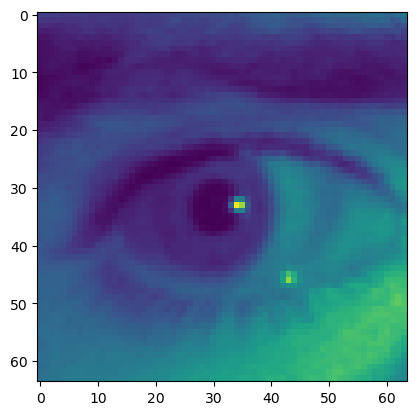

[[0.99999887]]
Open
1/1 [==============================] - 0s 25ms/step


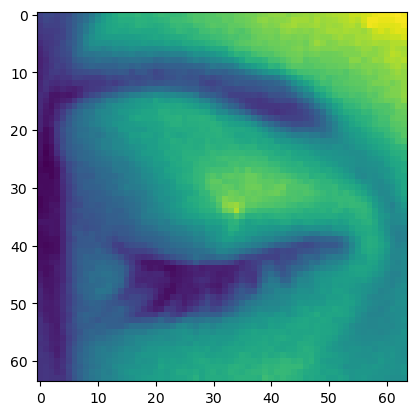

[[1.0551219e-06]]
Closed
1/1 [==============================] - 0s 19ms/step


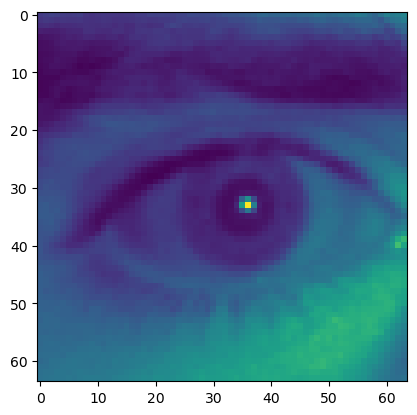

[[0.9999994]]
Open
1/1 [==============================] - 0s 22ms/step


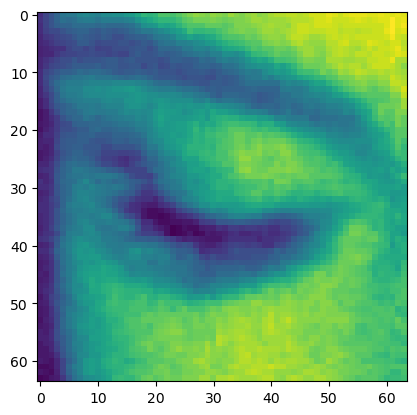

[[5.6707475e-05]]
Closed
1/1 [==============================] - 0s 21ms/step


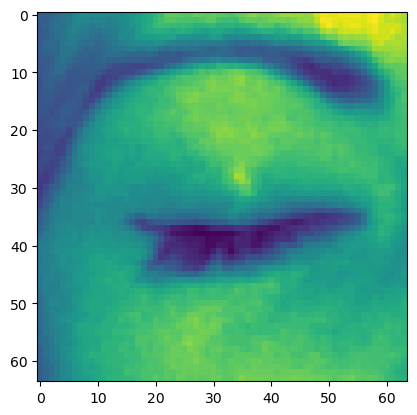

[[9.666862e-07]]
Closed
1/1 [==============================] - 0s 18ms/step


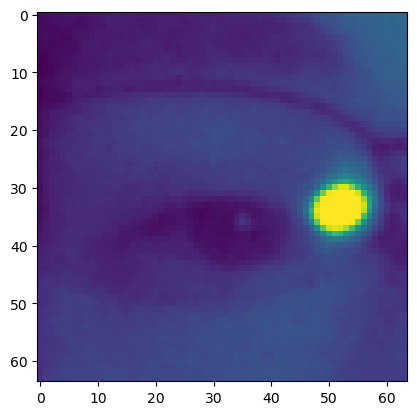

[[0.99931675]]
Open
1/1 [==============================] - 0s 20ms/step


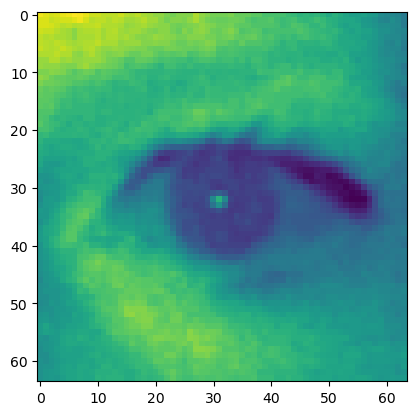

[[0.99999917]]
Open
1/1 [==============================] - 0s 20ms/step


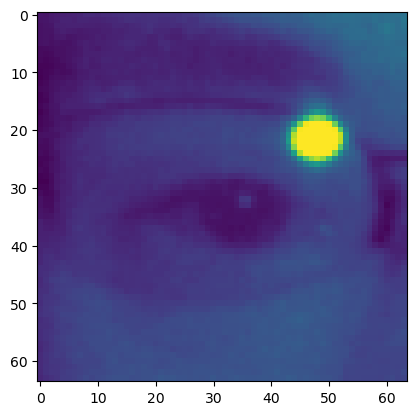

[[0.99998605]]
Open
1/1 [==============================] - 0s 21ms/step


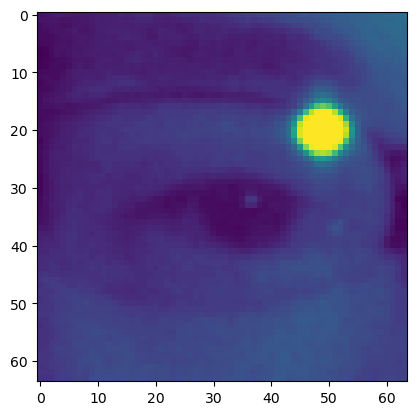

[[0.9999174]]
Open
1/1 [==============================] - 0s 20ms/step


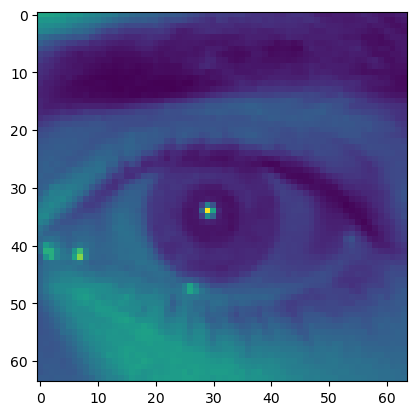

[[0.9999998]]
Open


In [30]:
for img in x_test[0:10]:
    test_img = np.expand_dims(img,0) #배치 차원 추가 (1,64,64,1)
    prediction = my_best_model.predict(test_img)
    plt.imshow(img)
    plt.show()
    print(prediction)
    if prediction > 0.5:
        print('Open')
    else:
        print("Closed")

### 8) Confusion Matrix 확인하기

38/38 [==============================] - 1s 20ms/step


Text(0.5, 80.7222222222222, 'Actual')

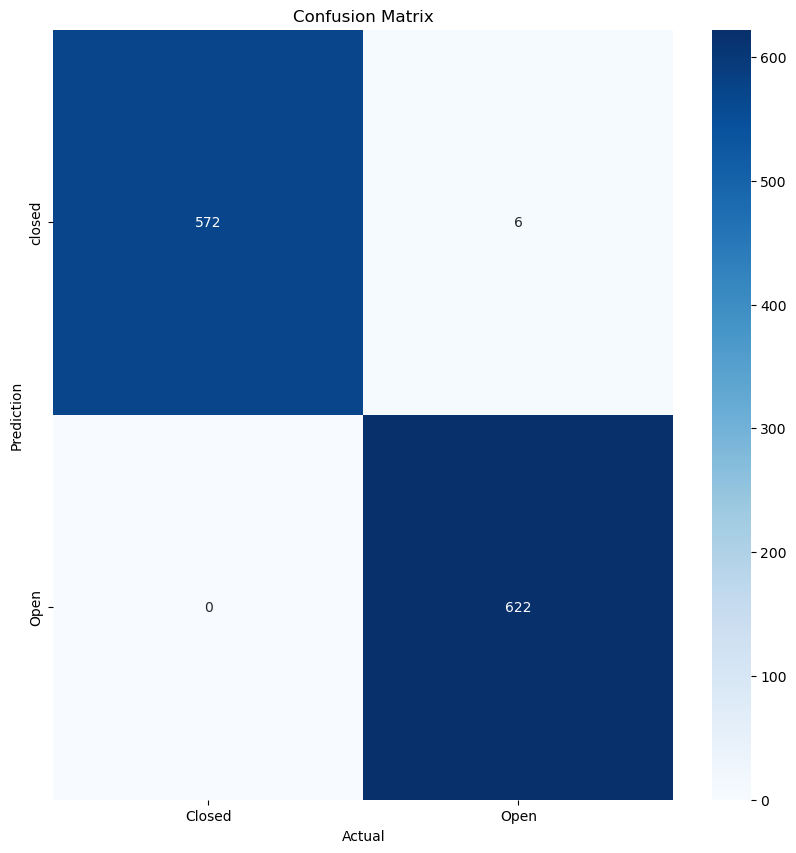

In [31]:
matrix_prediction = my_best_model.predict(x_test)
# Classification metrics can't handle a mix of binary and continuous targets 오류 해결
matrix_prediction = (matrix_prediction > 0.5).astype(np.int32)
ConfusionMatrix = confusion_matrix(y_test, matrix_prediction)
DF_CM = pd.DataFrame(ConfusionMatrix, index=['closed', 'Open'], columns=['Closed', 'Open'])

plt.figure(figsize=(10, 10))
plt.title("Confusion Matrix")
sns.heatmap(DF_CM, cbar = True, annot=True, fmt="d", cmap='Blues') 
#데이터, colorbar 유무, cell값 표기, cell 값 데이터타입, 히트맵 색
plt.ylabel("Prediction")
plt.xlabel("Actual")

# 2. 실시간 카메라로 졸음 탐지하기

**1. CNN 모델 만들기** 과정 없이, 함께 제출한 **PictureLearningModel.h5** 만 있어도 실행 가능 합니다.

#### 1) 얼굴 탐지기 (dlib) 와 landmark 탐지기 초기화
#### 2) 사전에 학습한 모델 불러오기
#### 3) 눈의 감김 상태를 확인할 함수 선언
#### 4) 졸았는지 졸지않았는지 판단하는 함수 선언
#### 5) 카메라 연결 및 탐지
#### (첨부) 아무 사진이나 predict 해볼 수 있는 코드

#### 1. cv2 가 없다는 오류가 뜨신다면

아나콘다 프롬프트에 입력합니다: `pip install opencv-python` 

<br />

#### 2. dlib 가 없다는 오류가 뜨신다면
1) http://dlib.net/ 에서 하단의 파란버튼 'Download dlib'를 누른 후, 다운로드합니다. 다운로드 된 압축파일은 아나콘다를 실행했을 때 나오는 기본 폴더에 풀어줍니다.

2) https://cmake.org/download/ 에서 운영체제에 맞는 설치파일을 다운로드 후, 설치합니다.

3) 아나콘다 프롬프트에 입력합니다: `pip install dlib`

<br />

#### 3. torch 가 없다는 오류가 뜨신다면
아나콘다 프롬프트에서 torch를 검색하여 pytorch와 torch를 다운로드 해줍니다. 

<br />

#### 4. imutils 가 없다는 오류가 뜨신다면
아나콘다 프롬프트에 입력합니다: `pip install imutils`

<br />

위의 모든 작업들을 진행하신 뒤에는 jupyter notebook을 재실행하시는 것을 권장드립니다.
감사합니다.

### 졸음 탐지를 할 때 필요한 라이브러리

In [32]:
import cv2 #opencv 라이브러리
import dlib #얼굴탐지를 도와주는 라이브러리
import numpy as np #데이터 전처리를 위해 사용됨
#import torch
#from imutils import face_utils 
from tensorflow.keras.models import load_model #모델을 불러오기 위해 사용하는 라이브러리
from collections import deque #졸음 탐지용 큐 라이브러리

### 1) 얼굴 탐지기 (dlib) 와 landmark 탐지기 초기화

dlib에서 사용되는 landmark 는 아래와 같습니다.

코드 상으로는 1이 아닌 0부터 시작되므로 모든 좌표값은 코드에서 +1 한 값이 사진의 값과 같습니다.

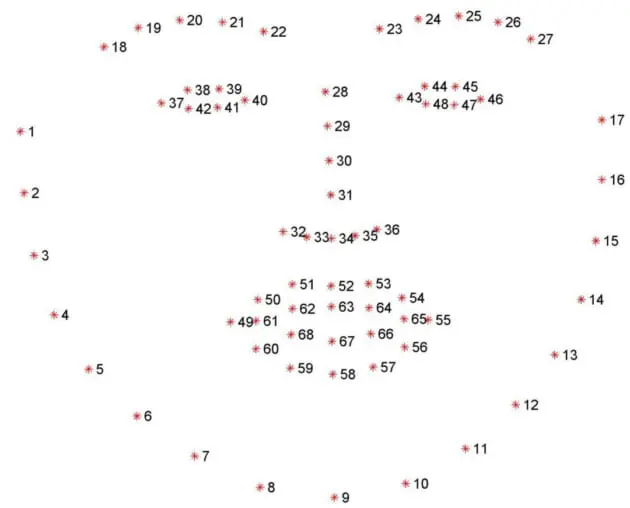

In [33]:
# 얼굴 탐지기와 랜드마크 탐지기 초기화
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat') #첨부파일에 함께 넣었습니다.

### 2) 사전에 학습한 모델 불러오기

In [34]:
# 사전에 학습한 모델을 불러옵니다.
model = load_model('PictureLearningModel.h5')

### 3) 눈의 감김 상태를 확인할 함수 선언

In [38]:
# 눈 감김 상태 확인 함수
def check_eye_status(eyes):
    # 입력 이미지 전처리
    img = cv2.resize(eyes, (64, 64))  # 이미지 크기 조절
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 이미지로 변환
    cv2.imwrite('./myeye.png', img)
    img = np.array(img) #np.array 화
    img = (np.array(img)-np.min(img))/(np.max(img)-np.min(img)) #min-max scailing
    img = img/255.0 #0~255 사이의 값으로
    img = np.expand_dims(img, axis=-1)  # 차원 확장 (64,64,1) [흑백이미지]
    img = np.expand_dims(img, axis=0)  # 배치 차원 추가 (1,64,64,1) 
    
    # 눈 감김 여부 확인
    prediction = model.predict(img)
    eye_status = prediction[0][0]
    return eye_status

### 4) 졸았는지 졸지않았는지 판단하는 함수 선언

In [36]:
# 눈의 상태를 저장할 큐
eye_status_queue = deque(maxlen=10)

# 일정 시간 동안 눈이 감긴 상태인지 확인하는 함수
def check_wake_up():
    if len(eye_status_queue) == 10 and all(status < 0.5 for status in eye_status_queue):
        return True
    else:
        return False

### 5) 카메라 연결 및 탐지

셀을 실행하면 카메라가 켜집니다. 앞을 응시하고 있으시면 됩니다.
q 버튼을 누르면 카메라가 꺼집니다.

In [39]:
# 카메라 연결
cap = cv2.VideoCapture(0)  # 카메라 장치 번호 (0은 기본 카메라)

# 탐지 시작
while True:
    # 카메라에서 프레임을 읽습니다.
    ret, frame = cap.read()
    
    if not ret:
        break

    # 얼굴 탐지
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)
    
    for face in faces:
        # 얼굴에서 랜드마크 탐지
        landmarks = landmark_predictor(gray, face)
        
        # 눈의 상태 확인
        left_eye_status = check_eye_status(frame[(landmarks.part(37).y)-10:(landmarks.part(41).y)+10, (landmarks.part(36).x)-10:(landmarks.part(39).x)+10])
        right_eye_status = check_eye_status(frame[(landmarks.part(43).y)-10:(landmarks.part(47).y)+10, (landmarks.part(42).x)-10:(landmarks.part(45).x)+10])
        
        # 눈의 상태를 큐에 저장
        eye_status_queue.append(left_eye_status)
        eye_status_queue.append(right_eye_status)
        
        # 눈 감김 상태 출력
        left_eye_label = 'Closed Eye' if left_eye_status < 0.5 else 'Open Eye'
        right_eye_label = 'Closed Eye' if right_eye_status < 0.5 else 'Open Eye'
        cv2.putText(frame, left_eye_label, (landmarks.part(36).x, landmarks.part(36).y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(frame, right_eye_label, (landmarks.part(42).x, landmarks.part(42).y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
        # 눈 감김이 지속되는지 확인하여 'wake up' 출력
        if check_wake_up():
            cv2.putText(frame, 'Wake up!', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # 결과 영상 표시
    cv2.imshow('Eye Detection', frame)
    
    # q 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 리소스 해제
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 28ms/step


### 6) 아무 사진 파일이나 검사해보는 코드

1/1 [==============================] - 0s 136ms/step


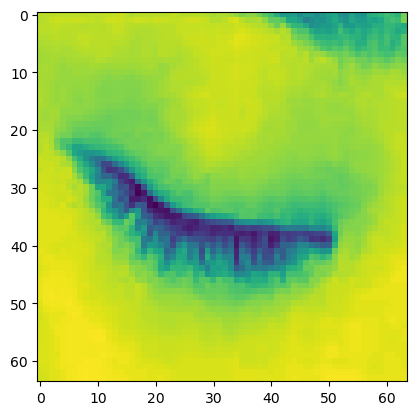

[[8.0353415e-14]]
Close


In [57]:
hymodel = load_model('PictureLearningModel.h5')
img = cv2.imread('./10.png') #사진 파일 경로를 적어주세요
img = cv2.resize(img, (64, 64))  # 이미지 크기 조절
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 이미지로 변환

img = np.array(img)
img = (np.array(img)-np.min(img))/(np.max(img)-np.min(img))
img = img/255.0

original_img = img
img = np.expand_dims(img, axis=-1)  # 차원 확장, (64, 64, 1)

prediction = hymodel.predict(np.expand_dims(img, 0)) #(1, 64, 64, 1)

plt.imshow(original_img)
plt.show()

print(prediction)
if prediction > 0.5:
    print('Open')
else:
    print('Close')